# Train/Test Split for Horse Detection Dataset

This notebook implements a train/test split for the horse detection dataset according to the following requirements:

1. Reserve 20% of the data for final evaluation
2. For absences: exclude any absence found within 2 meters of a presence (at any time point), then create spatial blocks using K-means clustering specifically for absences and sample 20% randomly from each block
3. For presences: group by zone and period, sampling 20% randomly from each group
4. Save each split in its own file and document in the Hugging Face markdown file

## Setup

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import random
import json

# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Load Ground Truth Data

In [ ]:
# Load ground truth data
groundtruth_path = '../data/vector/groundtruth.geojson'
gdf = gpd.read_file(groundtruth_path)

# Display basic information
print(f"Total points: {len(gdf)}")
print(f"Presence points: {len(gdf[gdf['Presence'] == 1])}")
print(f"Absence points: {len(gdf[gdf['Presence'] == 0])}")
print(f"Unique zones: {gdf['Zone'].unique()}")
print(f"Unique periods: {gdf['Period'].unique()}")

## Process Absences

1. Exclude absences within 2 meters of any presence
2. Group by spatial block
3. Sample 20% from each group for testing

Original absence points: 716


Filtering absences: 100%|██████████| 884/884 [00:00<00:00, 6460.38it/s]

Valid absence points (after removing those within 2m of presences): 706


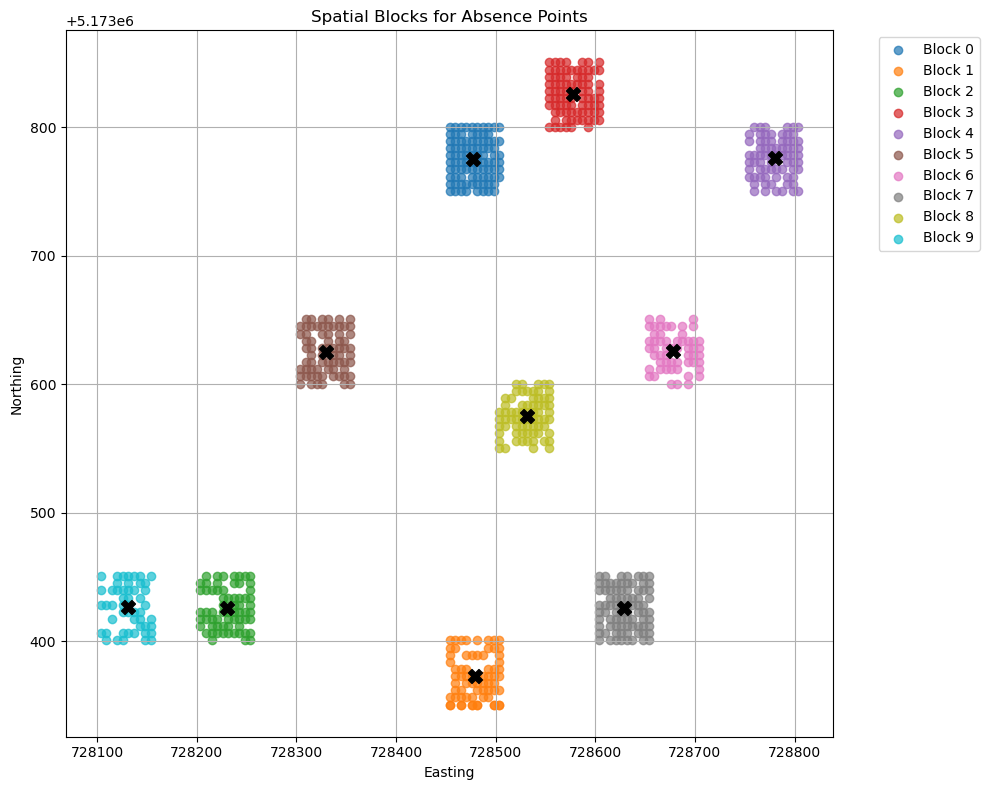

Distribution of absence points across spatial blocks:
Block 0: 91 points (12.9%)
Block 1: 69 points (9.8%)
Block 2: 65 points (9.2%)
Block 3: 82 points (11.6%)
Block 4: 72 points (10.2%)
Block 5: 70 points (9.9%)
Block 6: 56 points (7.9%)
Block 7: 82 points (11.6%)
Block 8: 69 points (9.8%)
Block 9: 50 points (7.1%)
Absence points for testing: 138
Absence points for training: 568


In [9]:
# Separate presence and absence points
presence_gdf = gdf[gdf['Presence'] == 1]
absence_gdf = gdf[gdf['Presence'] == 0]

print(f"Original absence points: {len(absence_gdf)}")

# Create a 2-meter buffer around each presence point
presence_buffers = presence_gdf.copy()
presence_buffers.geometry = presence_gdf.geometry.buffer(2)

# Find absences that are NOT within any presence buffer
valid_absences = absence_gdf.copy()
for idx, buffer in tqdm(presence_buffers.iterrows(), total=len(presence_buffers), desc="Filtering absences"):
    # Remove absences that intersect with this buffer
    valid_absences = valid_absences[~valid_absences.geometry.intersects(buffer.geometry)]

print(f"Valid absence points (after removing those within 2m of presences): {len(valid_absences)}")

# Create spatial blocks for absences using K-means clustering
# Extract coordinates for clustering
X = np.array(list(zip(valid_absences.geometry.x, valid_absences.geometry.y)))

# Define number of spatial blocks
n_clusters = 10

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
valid_absences['spatial_block'] = kmeans.fit_predict(X)

# Visualize the spatial blocks
plt.figure(figsize=(10, 8))
for block_id in range(n_clusters):
    block_points = valid_absences[valid_absences['spatial_block'] == block_id]
    plt.scatter(block_points.geometry.x, block_points.geometry.y, 
                label=f'Block {block_id}', alpha=0.7)
    
    # Calculate and plot the centroid
    centroid = kmeans.cluster_centers_[block_id]
    plt.scatter(centroid[0], centroid[1], s=100, c='black', marker='X')
    
plt.title('Spatial Blocks for Absence Points')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the distribution of points across spatial blocks
block_counts = valid_absences['spatial_block'].value_counts().sort_index()
print("Distribution of absence points across spatial blocks:")
for block_id, count in block_counts.items():
    print(f"Block {block_id}: {count} points ({count/len(valid_absences)*100:.1f}%)")

# Group valid absences by spatial block
absence_test_indices = []
absence_train_indices = []

for block_id in valid_absences['spatial_block'].unique():
    block_absences = valid_absences[valid_absences['spatial_block'] == block_id]
    
    # Sample 20% for testing
    test_size = max(1, int(0.2 * len(block_absences)))
    test_indices = block_absences.sample(n=test_size, random_state=RANDOM_SEED).index.tolist()
    train_indices = block_absences.index.difference(test_indices).tolist()
    
    absence_test_indices.extend(test_indices)
    absence_train_indices.extend(train_indices)

print(f"Absence points for testing: {len(absence_test_indices)}")
print(f"Absence points for training: {len(absence_train_indices)}")

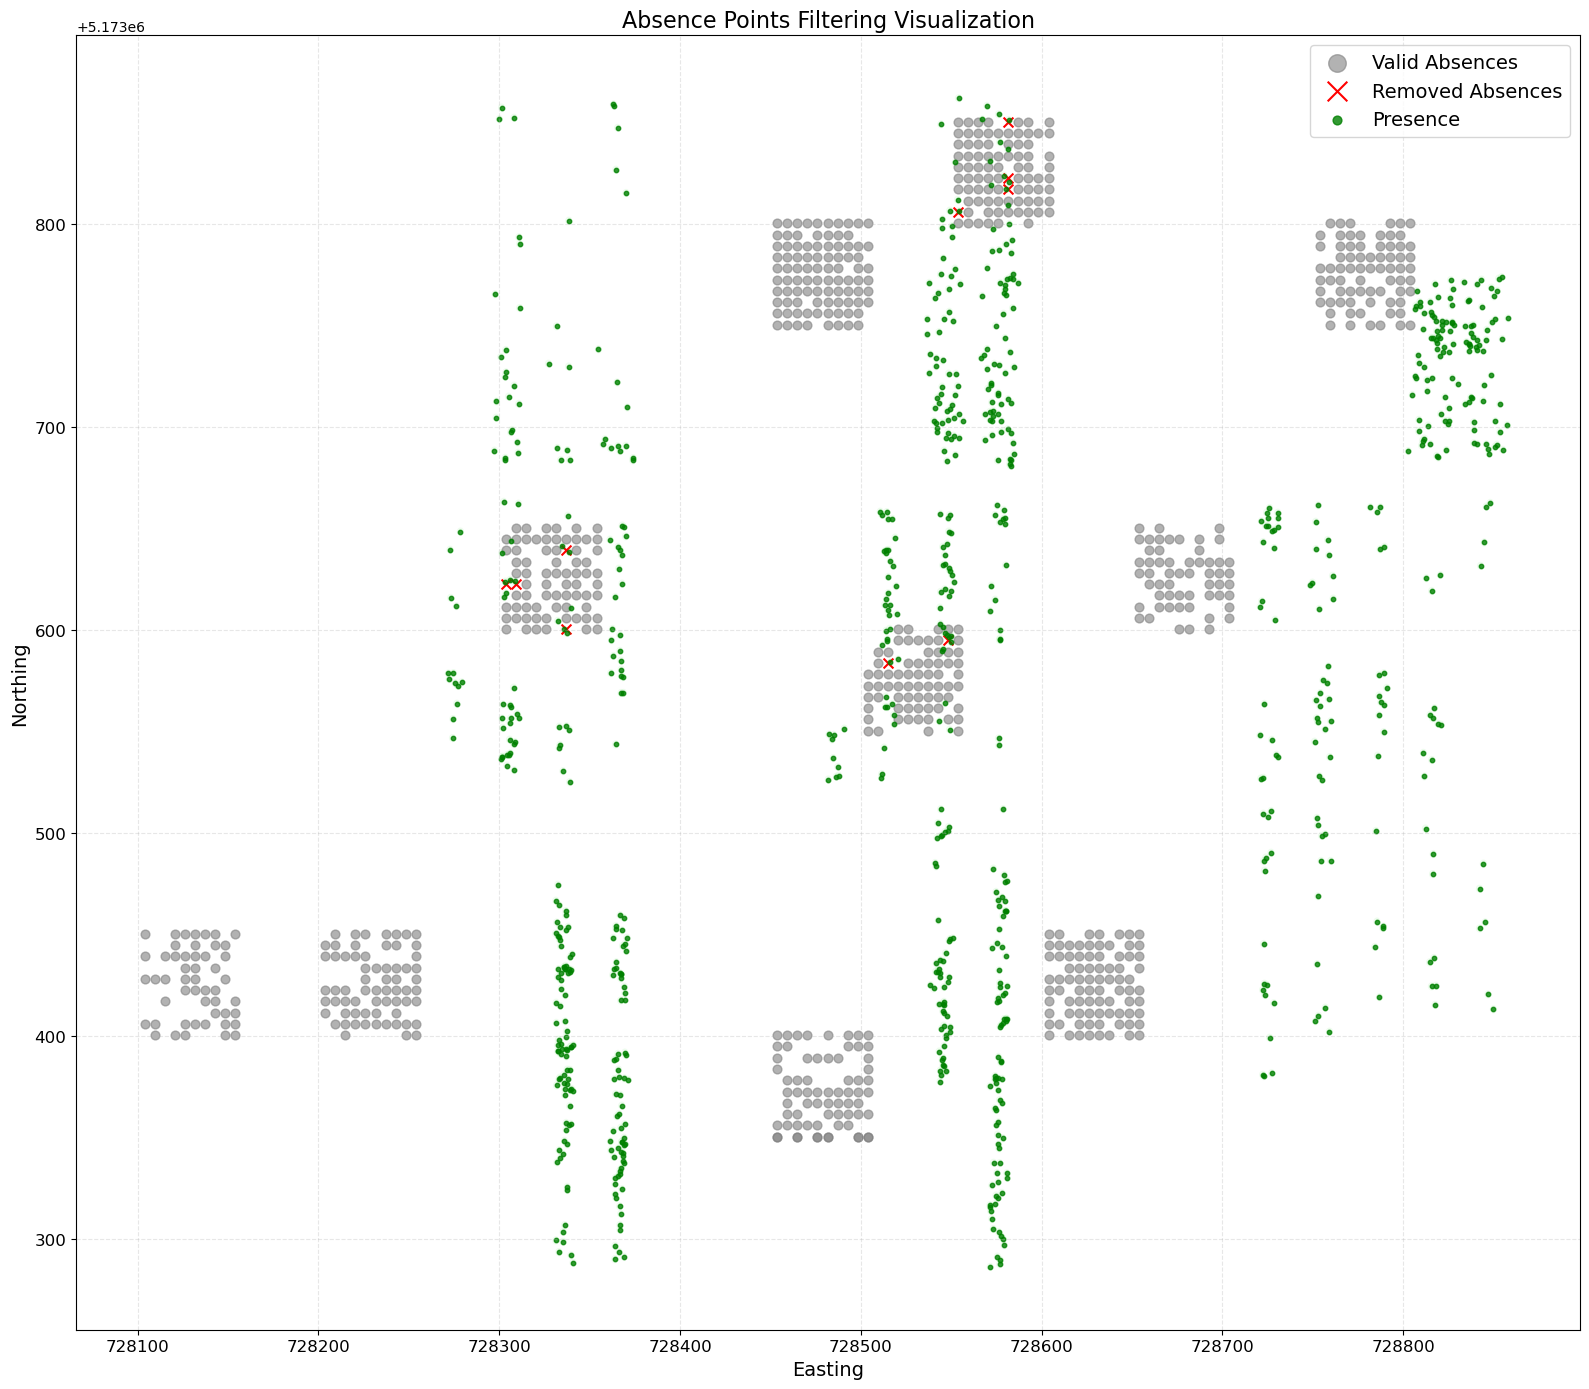

Removed absence points: 10 (1.4%)
Remaining valid absence points: 706 (98.6%)


In [13]:
# Create a map showing filtered absence points with improved legibility
plt.figure(figsize=(16, 14))

# First plot the 2-meter buffers around presence points (very light green)
for idx, buffer in presence_buffers.iterrows():
    x, y = buffer.geometry.exterior.xy
    plt.fill(x, y, alpha=0.15, fc='lightgreen', ec='none')

# Plot valid absence points (all in gray)
plt.scatter(valid_absences.geometry.x, valid_absences.geometry.y, 
            c='gray', marker='o', alpha=0.6, s=40, label='Valid Absences')

# Plot removed absence points as red X's
removed_absences = pd.Index(absence_gdf.index).difference(valid_absences.index)
if len(removed_absences) > 0:
    removed_points = absence_gdf.loc[removed_absences]
    plt.scatter(removed_points.geometry.x, removed_points.geometry.y, 
                c='red', marker='x', alpha=1.0, s=50, label='Removed Absences')

# Plot presence points as small green dots
plt.scatter(presence_gdf.geometry.x, presence_gdf.geometry.y, 
            c='green', marker='.', alpha=0.8, s=40, label='Presence')

# Add a title and labels with larger font
plt.title('Absence Points Filtering Visualization', fontsize=16)
plt.xlabel('Easting', fontsize=14)
plt.ylabel('Northing', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a grid but make it subtle
plt.grid(True, alpha=0.3, linestyle='--')

# Create a more readable legend with larger font
plt.legend(fontsize=14, markerscale=2, loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics
removed_count = len(absence_gdf) - len(valid_absences)
print(f"Removed absence points: {removed_count} ({removed_count/len(absence_gdf)*100:.1f}%)")
print(f"Remaining valid absence points: {len(valid_absences)} ({len(valid_absences)/len(absence_gdf)*100:.1f}%)")

## Process Presences

1. Group by zone and period
2. Sample 20% from each group for testing

In [ ]:
# Group presences by zone and period
presence_test_indices = []
presence_train_indices = []

for zone in presence_gdf['Zone'].unique():
    for period in presence_gdf['Period'].unique():
        group = presence_gdf[(presence_gdf['Zone'] == zone) & (presence_gdf['Period'] == period)]
        
        if len(group) == 0:
            continue
        
        # Sample 20% for testing
        test_size = max(1, int(0.2 * len(group)))
        test_indices = group.sample(n=test_size, random_state=RANDOM_SEED).index.tolist()
        train_indices = group.index.difference(test_indices).tolist()
        
        presence_test_indices.extend(test_indices)
        presence_train_indices.extend(train_indices)

print(f"Presence points for testing: {len(presence_test_indices)}")
print(f"Presence points for training: {len(presence_train_indices)}")

## Combine and Save Splits

In [ ]:
# Combine test and train indices
test_indices = presence_test_indices + absence_test_indices
train_indices = presence_train_indices + absence_train_indices

# Create test and train dataframes
test_gdf = gdf.loc[test_indices].copy()
train_gdf = gdf.loc[train_indices].copy()

# Verify the split
print(f"Total points: {len(gdf)}")
print(f"Training points: {len(train_gdf)} ({len(train_gdf)/len(gdf)*100:.1f}%)")
print(f"Testing points: {len(test_gdf)} ({len(test_gdf)/len(gdf)*100:.1f}%)")

# Check class distribution in each split
print("\nClass distribution in training set:")
print(train_gdf['Presence'].value_counts(normalize=True) * 100)

print("\nClass distribution in test set:")
print(test_gdf['Presence'].value_counts(normalize=True) * 100)

## Visualize the Split

In [ ]:
# Visualize the train/test split
plt.figure(figsize=(12, 10))

# Plot training points
plt.scatter(train_gdf[train_gdf['Presence'] == 1].geometry.x, 
            train_gdf[train_gdf['Presence'] == 1].geometry.y, 
            c='blue', marker='^', alpha=0.7, label='Train - Presence')
plt.scatter(train_gdf[train_gdf['Presence'] == 0].geometry.x, 
            train_gdf[train_gdf['Presence'] == 0].geometry.y, 
            c='lightblue', marker='o', alpha=0.7, label='Train - Absence')

# Plot testing points
plt.scatter(test_gdf[test_gdf['Presence'] == 1].geometry.x, 
            test_gdf[test_gdf['Presence'] == 1].geometry.y, 
            c='red', marker='^', alpha=0.7, label='Test - Presence')
plt.scatter(test_gdf[test_gdf['Presence'] == 0].geometry.x, 
            test_gdf[test_gdf['Presence'] == 0].geometry.y, 
            c='pink', marker='o', alpha=0.7, label='Test - Absence')

plt.title('Train/Test Split Visualization')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.legend()
plt.grid(True)
plt.show()

## Save the Splits

In [ ]:
# Create output directory
output_dir = '../data/processed/splits'
os.makedirs(output_dir, exist_ok=True)

# Save the GeoDataFrames
train_gdf.to_file(os.path.join(output_dir, 'train_split.geojson'), driver='GeoJSON')
test_gdf.to_file(os.path.join(output_dir, 'test_split.geojson'), driver='GeoJSON')

# Save the indices as JSON for reference
split_indices = {
    'train_indices': train_indices,
    'test_indices': test_indices,
    'metadata': {
        'random_seed': RANDOM_SEED,
        'train_size': len(train_indices),
        'test_size': len(test_indices),
        'train_presence_count': len(train_gdf[train_gdf['Presence'] == 1]),
        'train_absence_count': len(train_gdf[train_gdf['Presence'] == 0]),
        'test_presence_count': len(test_gdf[test_gdf['Presence'] == 1]),
        'test_absence_count': len(test_gdf[test_gdf['Presence'] == 0]),
    }
}

with open(os.path.join(output_dir, 'split_indices.json'), 'w') as f:
    json.dump(split_indices, f, indent=2)

print(f"Splits saved to {output_dir}")

## Create Hugging Face Dataset Documentation

In [ ]:
# Create Markdown documentation for Hugging Face
hf_markdown = f"""
# MPG Ranch Horse Detection Dataset - Train/Test Split

## Dataset Description

This dataset contains aerial imagery tiles for horse presence/absence detection at MPG Ranch. 
The data has been split into training and testing sets according to specific criteria.

## Split Methodology

The dataset was split into training (80%) and testing (20%) sets using the following criteria:

1. **Random Seed**: {RANDOM_SEED} (for reproducibility)
2. **Absence Points**: 
   - Excluded any absence found within 2 meters of a presence (at any time point)
   - Grouped by 10 spatial blocks created using K-means clustering
   - Sampled 20% randomly from each spatial block for testing
3. **Presence Points**:
   - Grouped by zone and period
   - Sampled 20% randomly from each group for testing

## Split Statistics

- **Total Points**: {len(gdf)}
- **Training Set**: {len(train_gdf)} points ({len(train_gdf)/len(gdf)*100:.1f}%)
  - Presence: {len(train_gdf[train_gdf['Presence'] == 1])}
  - Absence: {len(train_gdf[train_gdf['Presence'] == 0])}
- **Testing Set**: {len(test_gdf)} points ({len(test_gdf)/len(gdf)*100:.1f}%)
  - Presence: {len(test_gdf[test_gdf['Presence'] == 1])}
  - Absence: {len(test_gdf[test_gdf['Presence'] == 0])}

## Files

- `train_split.geojson`: GeoJSON file containing the training points
- `test_split.geojson`: GeoJSON file containing the testing points
- `split_indices.json`: JSON file containing the indices of the training and testing points

## Usage

```python
import geopandas as gpd

# Load the splits
train_gdf = gpd.read_file('train_split.geojson')
test_gdf = gpd.read_file('test_split.geojson')
```
"""

# Save the markdown file
with open(os.path.join(output_dir, 'README.md'), 'w') as f:
    f.write(hf_markdown)

print("Hugging Face documentation created.")